/var/folders/07/788q8g5d04qg3z2x8c2y1xcr0000gn/T/ipykernel_96827/2916988559.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['level'] = df['level'].replace(mapping)


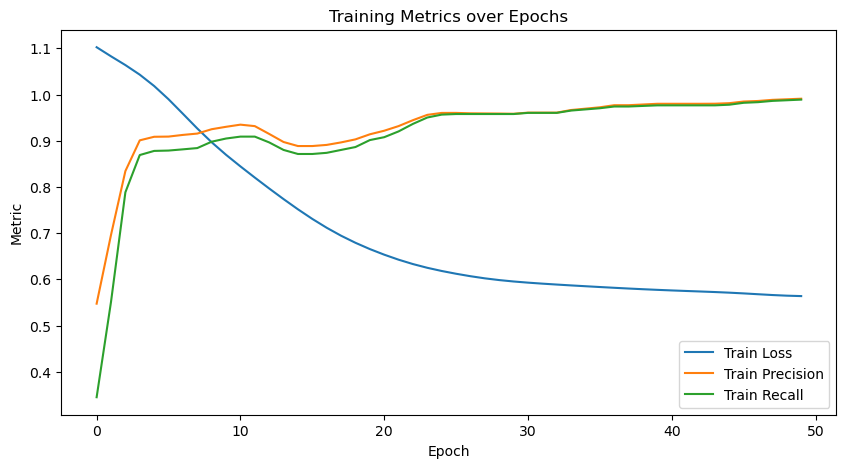

              precision    recall  f1-score   support

         Low       1.00      0.97      0.98        61
      Medium       1.00      1.00      1.00        66
        High       0.97      1.00      0.99        73

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [3]:
# -----------------------------
# 1️⃣ Import libraries
# -----------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# -----------------------------
# 2️⃣ Load and clean dataset
# -----------------------------
df = pd.read_csv("lungCancer_ds.csv")

if "Patient Id" in df.columns:
    df = df.drop(columns=["Patient Id"])

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

for s in ["dust_allergy","balanced_diet","frequent_cold","dry_cough","snoring"]:
    if s in df.columns:
        df = df.drop(columns=s)

mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['level'] = df['level'].replace(mapping)

# -----------------------------
# 3️⃣ Split features and target
# -----------------------------
X = df.drop(columns=["level"])
y = df["level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# -----------------------------
# 4️⃣ Define neural network
# -----------------------------
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 3),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# -----------------------------
# 5️⃣ Training loop with metrics
# -----------------------------
epochs = 50
train_loss_history = []
train_precision_history = []
train_recall_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Metrics
    with torch.no_grad():
        model.eval()
        pred_labels = torch.argmax(output, dim=1)
        precision = precision_score(y_train_tensor, pred_labels, average='macro', zero_division=0)
        recall = recall_score(y_train_tensor, pred_labels, average='macro', zero_division=0)
    
    train_loss_history.append(loss.item())
    train_precision_history.append(precision)
    train_recall_history.append(recall)

# -----------------------------
# 6️⃣ Plot metrics over epochs
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(train_precision_history, label='Train Precision')
plt.plot(train_recall_history, label='Train Recall')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Metrics over Epochs")
plt.legend()
plt.show()

# -----------------------------
# 7️⃣ Evaluate on test set
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred_test = torch.argmax(model(X_test_tensor), dim=1)
    from sklearn.metrics import classification_report
    print(classification_report(y_test_tensor, y_pred_test, target_names=["Low","Medium","High"]))    

In [7]:
# Save the entire model
torch.save(model, "lung_cancer_model.pth")

# Or save just the state dict (recommended)
torch.save(model.state_dict(), "lung_cancer_model_state.pth")